# Digits OCR

Source - https://www.kaggle.com/aakashnain/building-a-captcha-ocr-in-tf2-0/notebook

In [1]:
!pip install -q iterative-stratification

## Creating Data Structure

In [2]:
!mkdir data
%cd data
!mkdir raw external processed
!mkdir processed/train processed/test

/kaggle/working/data


In [3]:
!apt-get -qq install tree

debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package tree.
(Reading database ... 110556 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...


In [4]:
!tree .

.
├── external
├── processed
│   ├── test
│   └── train
└── raw

5 directories, 0 files


## Downloading Data

In [5]:
!wget -q http://13.234.225.243:9600/train_data.tar -O external/train_data.tar

In [6]:
!wget -q http://13.234.225.243:9600/test_data.tar -O external/test_data.tar 

In [7]:
!tar -xf external/train_data.tar -C raw/

In [8]:
!tar -xf external/test_data.tar -C raw/

In [9]:
!wget -q http://13.234.225.243:9600/train_data.csv -O raw/train_data/train_data.csv

In [10]:
!wget -q http://13.234.225.243:9600/sample_submission.csv -O raw/test_data/sample_submission.csv

## Utility Functions

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [12]:
sns.set_style("darkgrid")

In [13]:
def plot_grid(images, labels=None, h=5, w=5, title=""):
    f, ax = plt.subplots(h, w, figsize=(18, 18))
    random_indexes = random.sample(range(len(images)), k=h*w)
    for i, j in enumerate(random_indexes):
        ax[i // h, i % w].imshow(images[i])
        ax[i // h, i % w].axis("off")
        ax[i // h, i % w].set_title(labels[i], fontdict={"fontsize": 20})
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

In [14]:
def plot_hist(hist):
    plt.figure(figsize=(6, 6))
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()

## Extract DateField

In [15]:
from glob import glob

import cv2 as cv
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm


class ExtractRectangle:
    def __init__(self):
        super().__init__()

        self.minLinLength_h = 70
        self.minLinLength_v = 5
        self.maxLineGap = 20
        self.heights = []
        self.widths = []
        self.paths = []

    def is_horizontal(self, line, thresh=5):
        return abs(line[1] - line[3]) <= thresh

    def is_vertical(self, line, thresh=5):
        return abs(line[0] - line[2]) <= thresh

    def get_lines(self, canny, horizontal=True):
        lines = []
        if horizontal:
            linesP = cv.HoughLinesP(
                canny,
                rho=1,
                theta=np.pi / 180,
                threshold=10,
                lines=None,
                minLineLength=self.minLinLength_h,
                maxLineGap=20,
            )
        else:
            linesP = cv.HoughLinesP(
                canny,
                rho=1,
                theta=np.pi / 180,
                threshold=10,
                lines=None,
                minLineLength=self.minLinLength_v,
                maxLineGap=20,
            )
        if linesP is not None:
            for i in range(0, len(linesP)):
                l = linesP[i][0]
                if self.is_horizontal(l, 3) and horizontal:
                    lines.append(l)
                elif self.is_vertical(l, 3):
                    lines.append(l)
        return lines

    def remove_whitespace(self, img):
        # https://stackoverflow.com/questions/48395434/how-to-crop-or-remove-white-background-from-an-image
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        th, threshed = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV)

        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
        morphed = cv.morphologyEx(threshed, cv.MORPH_CLOSE, kernel)

        cnts = cv.findContours(morphed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[-2]
        cnt = sorted(cnts, key=cv.contourArea)[-1]

        x, y, w, h = cv.boundingRect(cnt)
        dst = img[y : y + h, x : x + w]
        return dst

    def process_image(self, filename, path):
        errenous = False
        img = cv.imread(cv.samples.findFile(filename))
        img = self.remove_whitespace(img)
        cImage = np.copy(img)

        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        canny = cv.Canny(gray, 100, 200)

        horizontal_lines = self.get_lines(canny)
        horizontal_lines = sorted(horizontal_lines, key=lambda a_entry: a_entry[..., 1])

        vertical_lines = self.get_lines(canny, horizontal=False)
        vertical_lines = sorted(vertical_lines, key=lambda a_entry: a_entry[..., 0])

        if len(horizontal_lines) > 0:
            initial_line = horizontal_lines[0]
            final_line = horizontal_lines[-1]

            # LeftTop(x1, y1) -> RightTop(x2, y1) -> RightBottom(x2, y2) -> LeftBottom(x1, y2)
            y1 = initial_line[1]
            y2 = final_line[1]
            bottom = min(y1, y2)
            top = max(y1, y2)

            # post whitespace removal, dates should only be the major component
            if (top - bottom) / img.shape[0] < 0.6:
                errenous = True
        else:
            errenous = True

        if len(vertical_lines) > 0:
            initial_line = vertical_lines[0]
            final_line = vertical_lines[-1]

            x1 = initial_line[0]
            x2 = final_line[0]
            left = min(x1, x2)
            right = max(x1, x2)

            # as dates occupy majority of the horizontal space
            if (right - left) / img.shape[1] <= 0.98:
                errenous = True
        else:
            errenous = True

        if not errenous:
            # cImage = cv.rectangle(cImage, (left, bottom), (right, top), (255, 0, 0), 2)
            cImage = cImage[
                bottom : bottom + (top - bottom), left : left + (right - left)
            ]
            self.paths.append(filename)
            self.heights.append(top - bottom)
            self.widths.append(right - left)
        cv.imwrite(f"{path}/{filename.split('/')[-1]}", cImage)

    def save_crop_info(self):
        df = pd.DataFrame(
            {"path": self.paths, "height": self.heights, "width": self.widths}
        )
        df.to_csv("cropped_image_info.csv", index=False)

In [16]:
extract = ExtractRectangle()
test_files = glob("raw/test_data/*.png")
test_path = "processed/test/"
for path in tqdm(test_files):
    extract.process_image(path, test_path)

train_files = glob("raw/train_data/*.png")
train_path = "processed/train/"
for path in tqdm(train_files):
    extract.process_image(path, train_path)

# saving crop info
extract.save_crop_info()

## Augment Data
**Method 1**

Crop cleaned images above such that 2 images with same areas are combined in the following way -
* Combine x digits of first image & y digits of second image such that x+y=8.
* Here, I loop from digits 1 to 4. That gives for a pair with same areas - 4 images

Combine the images in following ways -
* Initial part of both images
* Last part of first image & initial part of second image
* Initial part of first image & last part of second image
* Last part of both images

**Method 2**

For each image, take the first x digit & first y digits & stitch them horizontally. Loop x from 1-7, this mostly eliminates the last section of the image which only has [771, 781, 871, 881] as the last 3 digits in the original training data, hence creating some variation

In [17]:
import itertools
from PIL import Image


class DataAugmenter:
    def __init__(self):
        super(DataAugmenter).__init__()
        self.aug_path = []
        self.aug_labels = []
        train_data = pd.read_csv("raw/train_data/train_data.csv")[["tag", "label"]]
        train_data["label"] = train_data["label"].astype(str).str.zfill(8)
        self.train_data = dict(
            zip(train_data["tag"].tolist(), train_data["label"].tolist())
        )
        self.count = 10000

    def stitch_images_horizontally(
        self,
        inp_files,
        save_path,
        height,
        width,
        digits1=4,
        digits2=4,
        comb_type="type1",
    ):
        """
        Crops & stitches two images.
        Crops initial `digit1` & initial `digit2` digits from corresponding images & stitches them horizontally

        Arguments
        ---------
        inp_files - list
            List of image pair paths

        height - int
            Image height for both images.

        width - int
            Image width for both images

        digit1 - int
            Number of digits to take from first image

        digit2 - int
            Number of digits to take from second image

        comb_type - str
            Denotes combination type.
            type1 - Initial part of both images
            type2 - Last part of first image & initial part of second image
            type3 - Initial part of first image & last part of second image
            type4 - Last part of both images
        """

        images = [Image.open(x) for x in inp_files]

        w1 = int(width * (digits1 / 8))
        w2 = int(width * (digits2 / 8))

        if comb_type == "type1":
            img1_crop = images[0].crop((0, 0, w1, height))
            img2_crop = images[1].crop((0, 0, w2, height))
            images = [img1_crop, img2_crop]
        elif comb_type == "type2":
            img1_crop = images[0].crop((w1, 0, width, height))
            img2_crop = images[1].crop((0, 0, w2, height))
            images = [img1_crop, img2_crop]
        elif comb_type == "type3":
            img1_crop = images[0].crop((0, 0, w1, height))
            img2_crop = images[1].crop((w2, 0, width, height))
            images = [img1_crop, img2_crop]
        elif comb_type == "type4":
            img1_crop = images[0].crop((w1, 0, width, height))
            img2_crop = images[1].crop((w2, 0, width, height))
            images = [img1_crop, img2_crop]

        widths, heights = zip(*(i.size for i in images))
        total_width = sum(widths)
        max_height = min(heights)

        new_im = Image.new("RGB", (total_width, max_height))

        x_offset = 0
        for im in images:
            new_im.paste(im, (x_offset, 0))
            x_offset += im.size[0]
        new_im.save(save_path)

    def process(self):
        df = pd.read_csv("cropped_image_info.csv")
        df["area"] = df["height"].multiply(df["width"])
        df = df.loc[df["path"].str.contains("train")]
        df["tag"] = df["path"].apply(lambda x: int(x.split("/")[-1].split(".")[0]))
        df = df.sort_values(by="tag")
        df["path"] = df["path"].str.replace("raw/train_data/", "processed/train/")
        temp = dict(zip(df["tag"].tolist(), df["path"].tolist()))

        # find matching areas
        matching_areas = df["area"].value_counts()
        matching_areas = matching_areas[matching_areas > 2].index.tolist()
        # loop over matching areas
        for area in tqdm(matching_areas):
            # get height & width
            height = df.loc[df["area"] == area]["height"].iloc[0]
            width = df.loc[df["area"] == area]["width"].iloc[0]
            # create permutation based on tag
            all_combinations = list(
                itertools.combinations(
                    df.loc[df["area"] == area]["tag"].tolist()[:3], 2
                )
            )
            # for each combination
            for comb in all_combinations:
                tag1, tag2 = comb[0], comb[1]
                image1 = temp[tag1]
                image2 = temp[tag2]
                label1 = self.train_data[tag1]
                label2 = self.train_data[tag2]

                # variation based on number of digits per image - type1
                for digit1 in range(1, 7):
                    digit2 = 8 - digit1
                    self.count += 1
                    path = f"processed/train/{self.count}.png"
                    label = str(label1)[:digit1] + str(label2)[:digit2]
                    self.stitch_images_horizontally(
                        [image1, image2], path, height, width, digit1, digit2
                    )

                    self.aug_labels.append(label)
                    self.aug_path.append(path)

                # different types
                for comb_type in ["type2", "type3", "type4"]:
                    self.count += 1
                    path = f"processed/train/{self.count}.png"
                    if comb_type == "type2":
                        label = str(label1)[4:] + str(label2)[:4]
                    elif comb_type == "type3":
                        label = str(label1)[:4] + str(label2)[4:]
                    elif comb_type == "type4":
                        label = str(label1)[4:] + str(label2)[4:]

                    self.stitch_images_horizontally(
                        [image1, image2], path, height, width, comb_type=comb_type
                    )
                    self.aug_labels.append(label)
                    self.aug_path.append(path)

    def add_reverse(self):
        df = pd.read_csv("cropped_image_info.csv")
        df = df.loc[df["path"].str.contains("train")]
        df["tag"] = df["path"].apply(lambda x: int(x.split("/")[-1].split(".")[0]))
        df = df.sort_values(by="tag")
        df["path"] = df["path"].str.replace("raw/train_data/", "processed/train/")
        image_temp = dict(zip(df["tag"].tolist(), df["path"].tolist()))
        height_temp = dict(zip(df["tag"].tolist(), df["height"].tolist()))
        width_temp = dict(zip(df["tag"].tolist(), df["width"].tolist()))
        actual_df = pd.read_csv("raw/train_data/train_data.csv")
        actual_df = actual_df[["tag", "label"]]

        for tag in tqdm(df["tag"].tolist()):
            image = image_temp[tag]
            height = height_temp[tag]
            width = width_temp[tag]
            act_label = str(
                actual_df.loc[actual_df["tag"] == tag]["label"].tolist()[0]
            ).zfill(8)

            # variation based on number of digits per image - type1
            for digit1 in range(1, 7):
                digit2 = 8 - digit1
                self.count += 1
                path = f"processed/train/{self.count}.png"
                label = str(act_label)[:digit1] + str(act_label)[:digit2]
                self.stitch_images_horizontally(
                    [image, image], path, height, width, digit1, digit2
                )

                self.aug_labels.append(label)
                self.aug_path.append(path)
        updated_train_data = pd.DataFrame.from_dict(
            {"tag": self.aug_path, "label": self.aug_labels}
        )
        updated_train_data.to_csv("updated_train_data.csv", index=False)

In [18]:
augment = DataAugmenter()
augment.process()
x = augment.count
print(f"# AUGMENTED IMAGES: {x - 10000}")
augment.add_reverse()
print(f"# REVERSE IMAGES: {augment.count - x}")


# AUGMENTED IMAGES: 1053



# REVERSE IMAGES: 2418


## Digits OCR

In [19]:
from itertools import chain
import os
from pprint import pprint
import random
import requests

import cv2
import numpy as np
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.3.1


In [20]:
TEST_IMAGES_PATH = "processed/test/"
TRAIN_CSV_PATH = "updated_train_data.csv"
TRAIN_IMAGES_PATH = "processed/train/"

In [21]:
RANDOM_STATE = 42
NUM_SPLITS = 5

In [22]:
PUBLIC_host = "http://13.234.225.243"
SUBMISSION_URL = PUBLIC_host + ":8080/submit"
LEADERBOARD_URL = PUBLIC_host + ":8080/leaderboard"
DATA_URL = PUBLIC_host + ":9600"
TAG = "image_captioning_v1"

In [23]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = str(seed)

seed_everything(RANDOM_STATE)

In [24]:
data_dir = Path("processed/train/")
images = list(data_dir.glob("*.png"))
print(f"# Training Images: {len(images)}")

# Training Images: 13471


In [25]:
test_data_dir = Path("processed/test/")
test_images = list(test_data_dir.glob("*.png"))
print(f"# Test Images: {len(test_images)}")

# Test Images: 1000


In [26]:
df = pd.read_csv(TRAIN_CSV_PATH)
x = pd.read_csv("raw/train_data/train_data.csv")

In [27]:
df["tag"] = df["tag"].apply(lambda x: int(x.split("/")[-1].split(".")[0]))

In [28]:
df = df.append(x)
df["tag"] = df["tag"].astype(int)
df = df.sort_values(by="tag")

In [29]:
df["label"] = df["label"].astype(str)
df["label"] = df["label"].str.zfill(8)

In [30]:
characters = set()
captcha_length = []
dataset = []

In [31]:
for img_path in images:
    label = df.loc[df["tag"]==int(img_path.stem)]["label"].tolist()[0]
    captcha_length.append(len(label))
    dataset.append((str(img_path), label))

    for ch in label:
        characters.add(ch)

In [32]:
characters = sorted(characters)
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)
dataset = dataset.sample(frac=1.).reset_index(drop=True)

print(f"# Unique Characters: {len(characters)}")
print(f"Max Length: {max(Counter(captcha_length).keys())}")
print(f"Digits Present: {characters}")
print(f"# Samples: {len(dataset)}")

# Unique Characters: 10
Max Length: 8
Digits Present: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# Samples: 13471


In [33]:
# digits distribution
for i in range(10):
    dataset[i] = dataset["label"].str.count(str(i))

In [34]:
dataset.head()

img_path     label  0  1  2  3  4  5  6  7  8  9
0  processed/train/10740.png  92994437  0  0  1  1  2  0  0  1  0  3
1  processed/train/10285.png  69445728  0  0  1  0  2  1  1  1  1  1
2   processed/train/5414.png  76556781  0  1  0  0  0  2  2  2  1  0
3   processed/train/6213.png  81834771  0  2  0  1  1  0  0  2  2  0
4   processed/train/6772.png  48462771  0  1  1  0  2  0  1  2  1  0

In [35]:
for i in range(10):
    print(f"{i} - {dataset[i].sum()}")

0 - 5820
1 - 16689
2 - 8632
3 - 8897
4 - 8688
5 - 8965
6 - 8762
7 - 17845
8 - 17314
9 - 6156


In [36]:
char_to_labels = {char:idx for idx, char in enumerate(characters)}
labels_to_char = {val:key for key, val in char_to_labels.items()}

In [37]:
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True

In [38]:
def generate_arrays(df, resize=True, img_height=50, img_width=200):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # Add only if it is a valid captcha
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)

### Model

In [39]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss

In [40]:
def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # First conv block
    x = layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
    # Second conv block
    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(characters)+1,
              activation='softmax', 
              name='dense2',
              kernel_initializer='he_normal')(x)
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    
    # Compile the model and return 
    model.compile(optimizer=sgd)
    return model

### DataGenerator

In [41]:
class DataGenerator(keras.utils.Sequence):
    """Generates batches from a given dataset.

    Args:
        data: training or validation data
        labels: corresponding labels
        char_map: dictionary mapping char to labels
        batch_size: size of a single batch
        img_width: width of the resized
        img_height: height of the resized
        downsample_factor: by what factor did the CNN downsample the images
        max_length: maximum length of any captcha
        shuffle: whether to shuffle data or not after each epoch
    Returns:
        batch_inputs: a dictionary containing batch inputs
        batch_labels: a batch of corresponding labels
    """

    def __init__(
        self,
        data,
        labels,
        char_map,
        batch_size=16,
        img_width=200,
        img_height=50,
        downsample_factor=4,
        max_length=5,
        shuffle=True,
    ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]

        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size
        batch_len = len(curr_batch_idx)

        # 3. Instantiate batch arrays
        batch_images = np.ones(
            (batch_len, self.img_width, self.img_height, 1), dtype=np.float32
        )
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * (
            self.img_width // self.downsample_factor - 2
        )
        label_length = np.zeros((batch_len, 1), dtype=np.int64)

        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            # 3. Get the correpsonding label
            text = self.labels[idx]
            # 4. Include the pair only if the captcha is valid
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)

        batch_inputs = {
            "input_data": batch_images,
            "input_label": batch_labels,
            "input_length": input_length,
            "label_length": label_length,
        }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [42]:
batch_size = 16
downsample_factor = 4
epochs = 50
max_length = 8

img_width = 200
img_height = 50

In [43]:
params = {"char_map": char_to_labels, 
          "batch_size": batch_size, 
          "img_width": img_width, 
          "img_height": img_height,
          "downsample_factor": downsample_factor, 
          "max_length": max_length
}

### Training

In [44]:
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    # greedy search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    output_text = []
    for res in results.numpy():
        outstr = ""
        for c in res:
            if c < len(characters) and c >= 0:
                outstr += labels_to_char[c]
        output_text.append(outstr)

    return output_text

In [45]:
def get_all_preds(prediction_model, data_generator):
    """
    Utility function that returns both model pprediction & actual labels
    """
    decoded_text, actuals_text = [], []
    for p, (inp_value, _) in tqdm(enumerate(data_generator)):
        bs = inp_value["input_data"].shape[0]
        X_data = inp_value["input_data"]
        labels = inp_value["input_label"]

        preds = prediction_model.predict(X_data)
        pred_texts = decode_batch_predictions(preds)

        orig_texts = []
        for label in labels:
            text = "".join([labels_to_char[int(x)] for x in label])
            orig_texts.append(text)

        decoded_text.append([pred_texts[i] for i in range(bs)])
        actuals_text.append([orig_texts[i] for i in range(bs)])

    # flatten 2D list
    decoded_text = list(chain.from_iterable(decoded_text))
    actuals_text = list(chain.from_iterable(actuals_text))
    return decoded_text, actuals_text

In [46]:
kfold = MultilabelStratifiedKFold(n_splits=NUM_SPLITS, shuffle=True, random_state=RANDOM_STATE)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


****************************
*          FOLD 0          *
****************************
Epoch 1/50
674/674 [==============================] - 160s 237ms/step - loss: 15.7936 - val_loss: 11.5585
Epoch 2/50
674/674 [==============================] - 158s 235ms/step - loss: 6.3896 - val_loss: 2.1322
Epoch 3/50
674/674 [==============================] - 161s 238ms/step - loss: 2.2589 - val_loss: 1.2221
Epoch 4/50
674/674 [==============================] - 159s 236ms/step - loss: 1.4855 - val_loss: 0.8687
Epoch 5/50
674/674 [==============================] - 161s 239ms/step - loss: 1.1387 - val_loss: 0.7244
Epoch 6/50
674/674 [==============================] - 159s 236ms/step - loss: 0.9471 - val_loss: 0.6055
Epoch 7/50
674/674 [==============================] - 164s 244ms/step - loss: 0.8188 - val_loss: 0.5585
Epoch 8/50
674/674 [==============================] - 163s 241ms/step - loss: 0.7159 - val_loss: 0.4432
Epoch 9/50
674/674 [==============================] - 163s 242ms/step - loss: 0

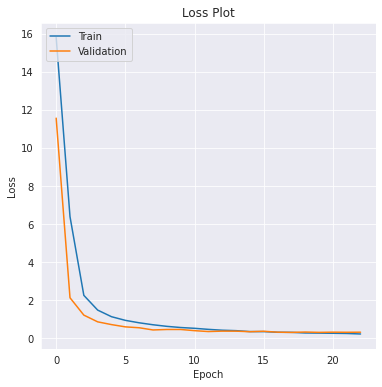


Validation Accuracy: 0.9290
****************************
*          FOLD 1          *
****************************
Epoch 1/50
673/673 [==============================] - 163s 242ms/step - loss: 16.7038 - val_loss: 11.6783
Epoch 2/50
673/673 [==============================] - 165s 245ms/step - loss: 6.8217 - val_loss: 2.4859
Epoch 3/50
673/673 [==============================] - 163s 242ms/step - loss: 2.6133 - val_loss: 1.3656
Epoch 4/50
673/673 [==============================] - 162s 241ms/step - loss: 1.7044 - val_loss: 1.0544
Epoch 5/50
673/673 [==============================] - 162s 241ms/step - loss: 1.2746 - val_loss: 0.9107
Epoch 6/50
673/673 [==============================] - 164s 243ms/step - loss: 1.0167 - val_loss: 0.6108
Epoch 7/50
673/673 [==============================] - 165s 245ms/step - loss: 0.8485 - val_loss: 0.6237
Epoch 8/50
673/673 [==============================] - 163s 242ms/step - loss: 0.7506 - val_loss: 0.5033
Epoch 9/50
673/673 [==============================

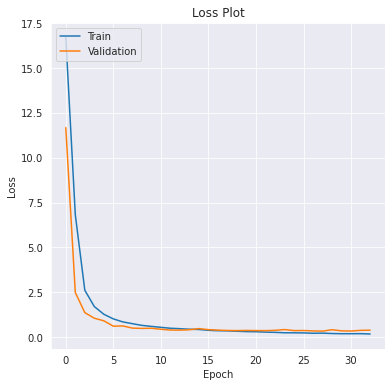


Validation Accuracy: 0.9268
****************************
*          FOLD 2          *
****************************
Epoch 1/50
674/674 [==============================] - 172s 255ms/step - loss: 16.3156 - val_loss: 12.6079
Epoch 2/50
674/674 [==============================] - 175s 260ms/step - loss: 7.4433 - val_loss: 2.6330
Epoch 3/50
674/674 [==============================] - 173s 257ms/step - loss: 2.5524 - val_loss: 1.2607
Epoch 4/50
674/674 [==============================] - 169s 250ms/step - loss: 1.6354 - val_loss: 0.9977
Epoch 5/50
674/674 [==============================] - 165s 245ms/step - loss: 1.2140 - val_loss: 0.7859
Epoch 6/50
674/674 [==============================] - 169s 250ms/step - loss: 0.9876 - val_loss: 0.7775
Epoch 7/50
674/674 [==============================] - 173s 256ms/step - loss: 0.8007 - val_loss: 0.5480
Epoch 8/50
674/674 [==============================] - 171s 254ms/step - loss: 0.6925 - val_loss: 0.5830
Epoch 9/50
674/674 [==============================

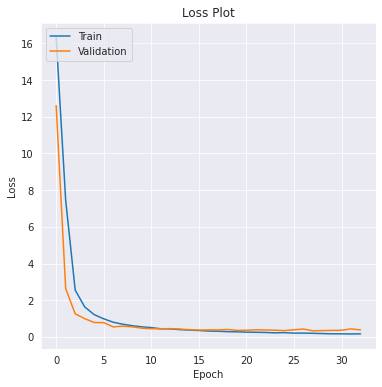


Validation Accuracy: 0.9248
****************************
*          FOLD 3          *
****************************
Epoch 1/50
674/674 [==============================] - 175s 259ms/step - loss: 17.0632 - val_loss: 14.1803
Epoch 2/50
674/674 [==============================] - 163s 242ms/step - loss: 9.6192 - val_loss: 3.7155
Epoch 3/50
674/674 [==============================] - 175s 259ms/step - loss: 3.0149 - val_loss: 1.5701
Epoch 4/50
674/674 [==============================] - 165s 245ms/step - loss: 1.6948 - val_loss: 0.7856
Epoch 5/50
674/674 [==============================] - 163s 242ms/step - loss: 1.2307 - val_loss: 0.7733
Epoch 6/50
674/674 [==============================] - 171s 253ms/step - loss: 0.9858 - val_loss: 0.5298
Epoch 7/50
674/674 [==============================] - 159s 237ms/step - loss: 0.8119 - val_loss: 0.5705
Epoch 8/50
674/674 [==============================] - 169s 251ms/step - loss: 0.7218 - val_loss: 0.4685
Epoch 9/50
674/674 [==============================

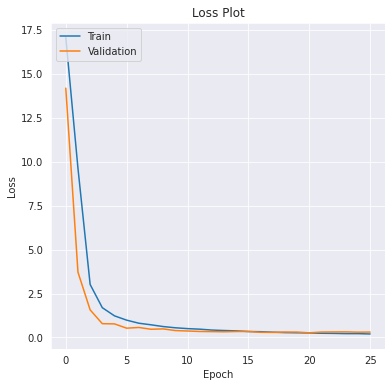


Validation Accuracy: 0.9330
****************************
*          FOLD 4          *
****************************
Epoch 1/50
674/674 [==============================] - 172s 255ms/step - loss: 16.1550 - val_loss: 12.5937
Epoch 2/50
674/674 [==============================] - 171s 254ms/step - loss: 7.0249 - val_loss: 2.2926
Epoch 3/50
674/674 [==============================] - 157s 234ms/step - loss: 2.3331 - val_loss: 1.2192
Epoch 4/50
674/674 [==============================] - 171s 254ms/step - loss: 1.4825 - val_loss: 0.9635
Epoch 5/50
674/674 [==============================] - 157s 233ms/step - loss: 1.0951 - val_loss: 0.7060
Epoch 6/50
674/674 [==============================] - 173s 256ms/step - loss: 0.8892 - val_loss: 0.6527
Epoch 7/50
674/674 [==============================] - 158s 234ms/step - loss: 0.7503 - val_loss: 0.5541
Epoch 8/50
674/674 [==============================] - 170s 253ms/step - loss: 0.6547 - val_loss: 0.6606
Epoch 9/50
674/674 [==============================

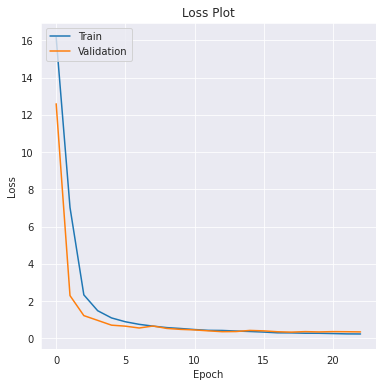


Validation Accuracy: 0.9227


In [47]:
indexes, preds, labels, folds = [], [], [], []
for fold, (train_idx, valid_idx) in enumerate(kfold.split(X=dataset["img_path"], 
                                                          y=dataset[range(10)])):
    print("*"*28)
    print("*"+" "*10+f"FOLD {fold}"+" "*10+"*")
    print("*"*28)

    es = keras.callbacks.EarlyStopping(monitor="val_loss",
                                   patience=5,
                                   restore_best_weights=True)

    training_data = dataset.iloc[train_idx].reset_index(drop=True)
    validation_data = dataset.iloc[valid_idx].reset_index(drop=True)
    
    training_data, training_labels = generate_arrays(df=training_data)
    validation_data, validation_labels = generate_arrays(df=validation_data)

    train_data_generator = DataGenerator(data=training_data,
                                         labels=training_labels,
                                         shuffle=True,
                                         **params
                                        )
    valid_data_generator = DataGenerator(data=validation_data,
                                         labels=validation_labels,
                                         shuffle=False,
                                         **params)
    
    model = build_model()
    history = model.fit(train_data_generator,
                        validation_data=valid_data_generator,
                        epochs=epochs,
                        callbacks=[es])
    plot_hist(history)
    model.save(f"digits_ocr_fold_{fold}.h5")
    
    
    prediction_model = keras.models.Model(model.get_layer(name="input_data").input, 
                                          model.get_layer(name="dense2").output)
    # get validation preds
    decoded_text, actuals_text = get_all_preds(prediction_model, valid_data_generator)
    print(f"Validation Accuracy: {accuracy_score(actuals_text, decoded_text):.4f}")
    
    # store validation indexes, prediction, label & fold
    indexes.append(valid_idx)
    preds.append(decoded_text)
    labels.append(actuals_text)
    folds.append([fold]*len(valid_idx))

In [48]:
indexes = list(chain.from_iterable(indexes))
preds = list(chain.from_iterable(preds))
labels = list(chain.from_iterable(labels))
folds = list(chain.from_iterable(folds))

In [49]:
valid_data_pred = pd.DataFrame({"index": indexes, "prediction": preds, "label":  labels, "fold": folds})

In [50]:
valid_data_pred = valid_data_pred.merge(dataset["img_path"], left_on="index", right_index=True)

In [51]:
valid_data_pred.head()

index prediction     label  fold                   img_path
0      2   76556781  76556781     0   processed/train/5414.png
1     12   65275138  65275138     0  processed/train/10563.png
2     17   07515871  07515871     0   processed/train/9803.png
3     18   25435881  25435881     0      processed/train/9.png
4     24   65092771  65092771     0    processed/train/511.png

In [52]:
print(f"OOF Accuracy: {accuracy_score(valid_data_pred['label'].tolist(), valid_data_pred['prediction'].tolist())}")

OOF Accuracy: 0.9272511320614654


In [53]:
data, _ = generate_arrays(df=valid_data_pred)

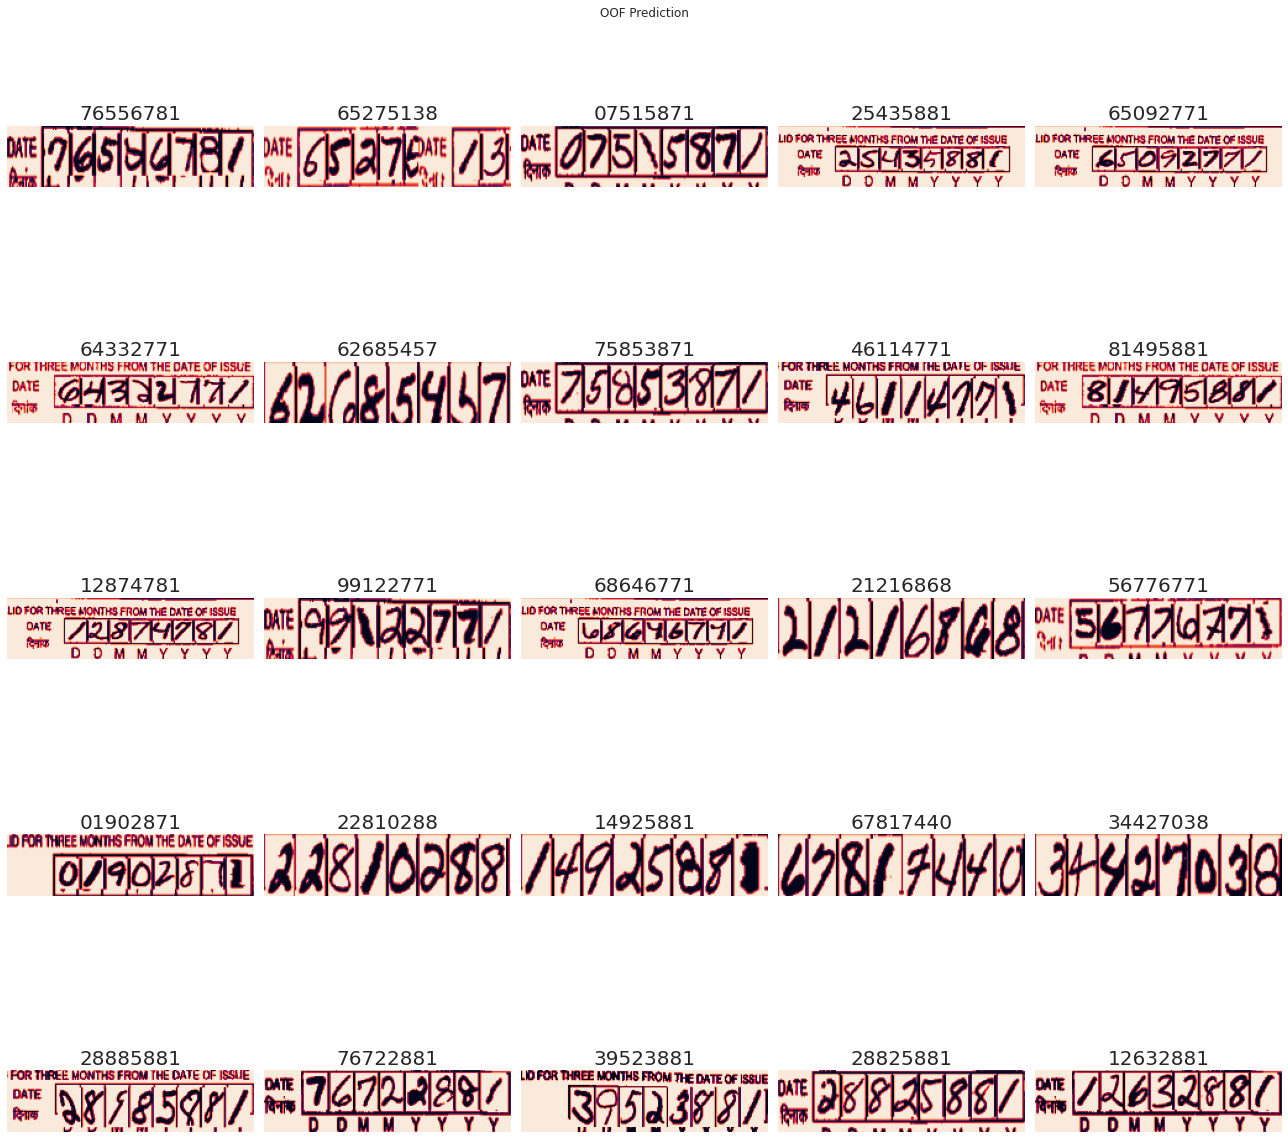

In [54]:
plot_grid(data, valid_data_pred["prediction"].tolist(), title="OOF Prediction")

## Test Data Prediction

In [55]:
test_df = pd.read_csv("raw/test_data/sample_submission.csv")
test_df["img_path"] = test_df["tag"].apply(lambda x: f"processed/test/{x}.png")
test_df["label"] = test_df["label"].astype(str)

In [56]:
# Build testing data
testing_data, testing_labels = generate_arrays(df=test_df)
print(f"# Test Images: {testing_data.shape[0]}")

# Test Images: 1000


In [57]:
test_data_generator = DataGenerator(data=testing_data,
                                    labels=testing_labels, # fake labels
                                    shuffle=False, 
                                    **params
                                    )

**PostProcessing**
* Predicted label length=9 - Remove the last 1

In [58]:
def remove_last_one(label):
    idx = label.rfind("1")
    return label[:idx] + label[idx+1:]

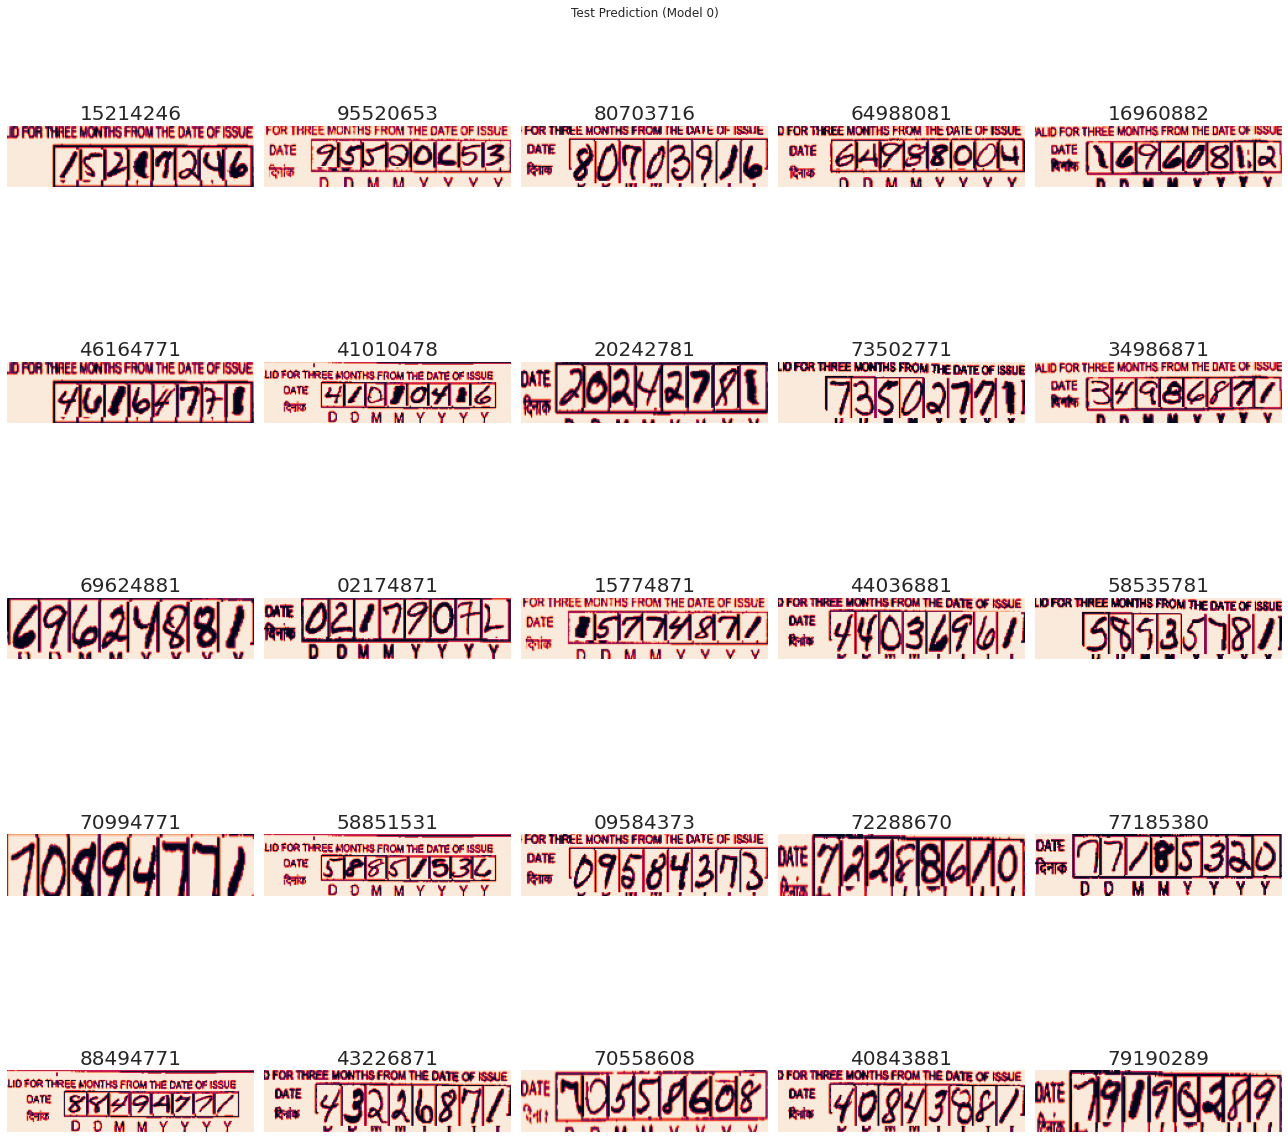

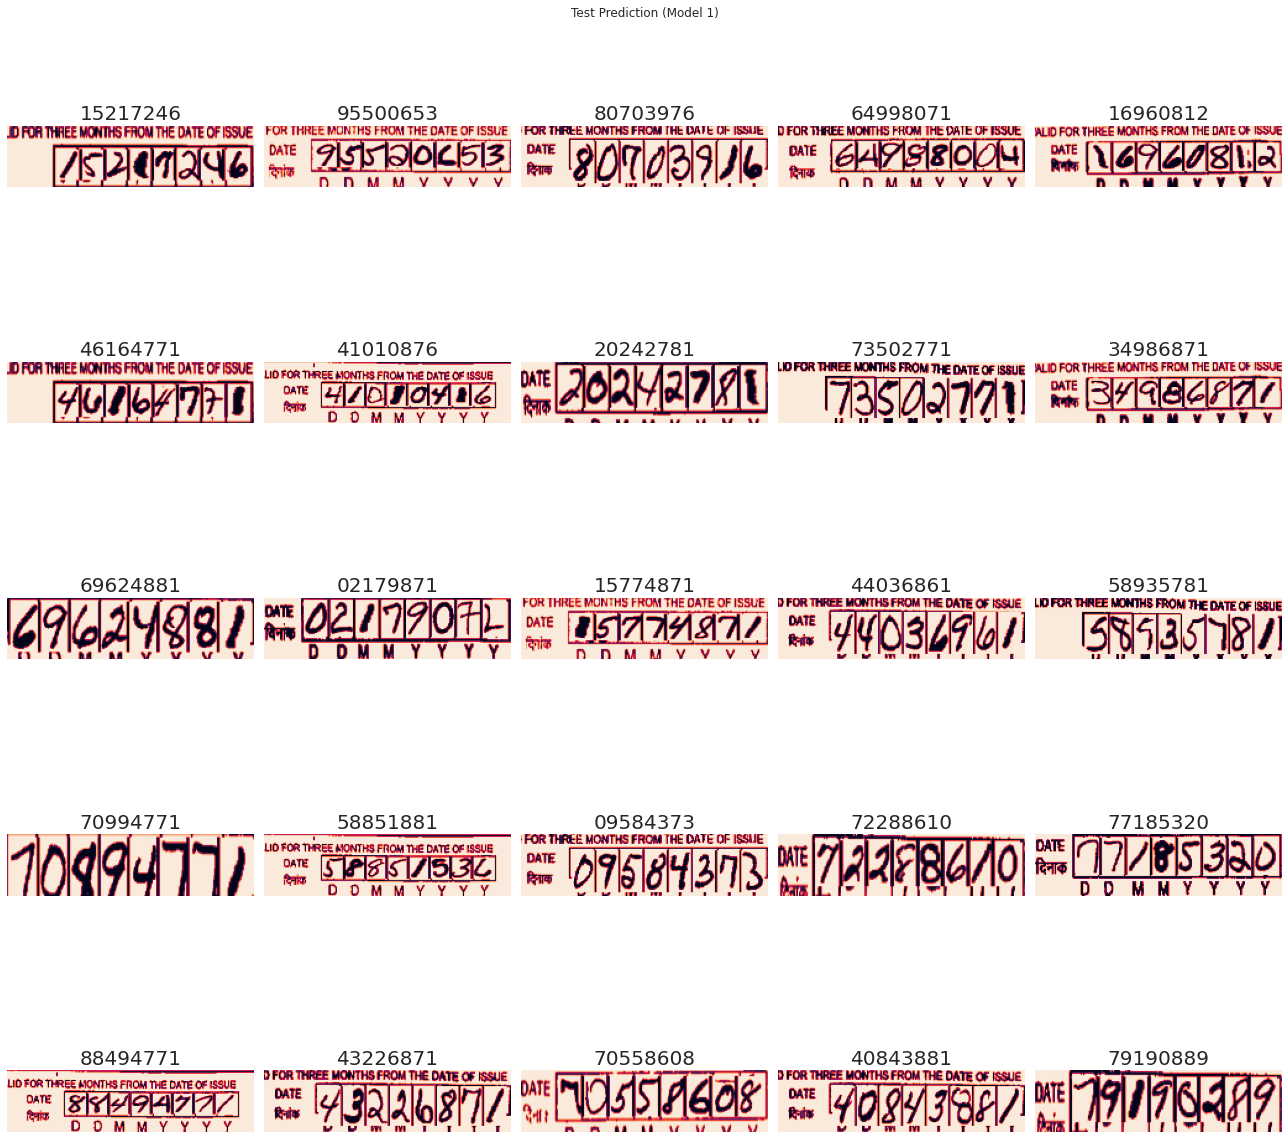

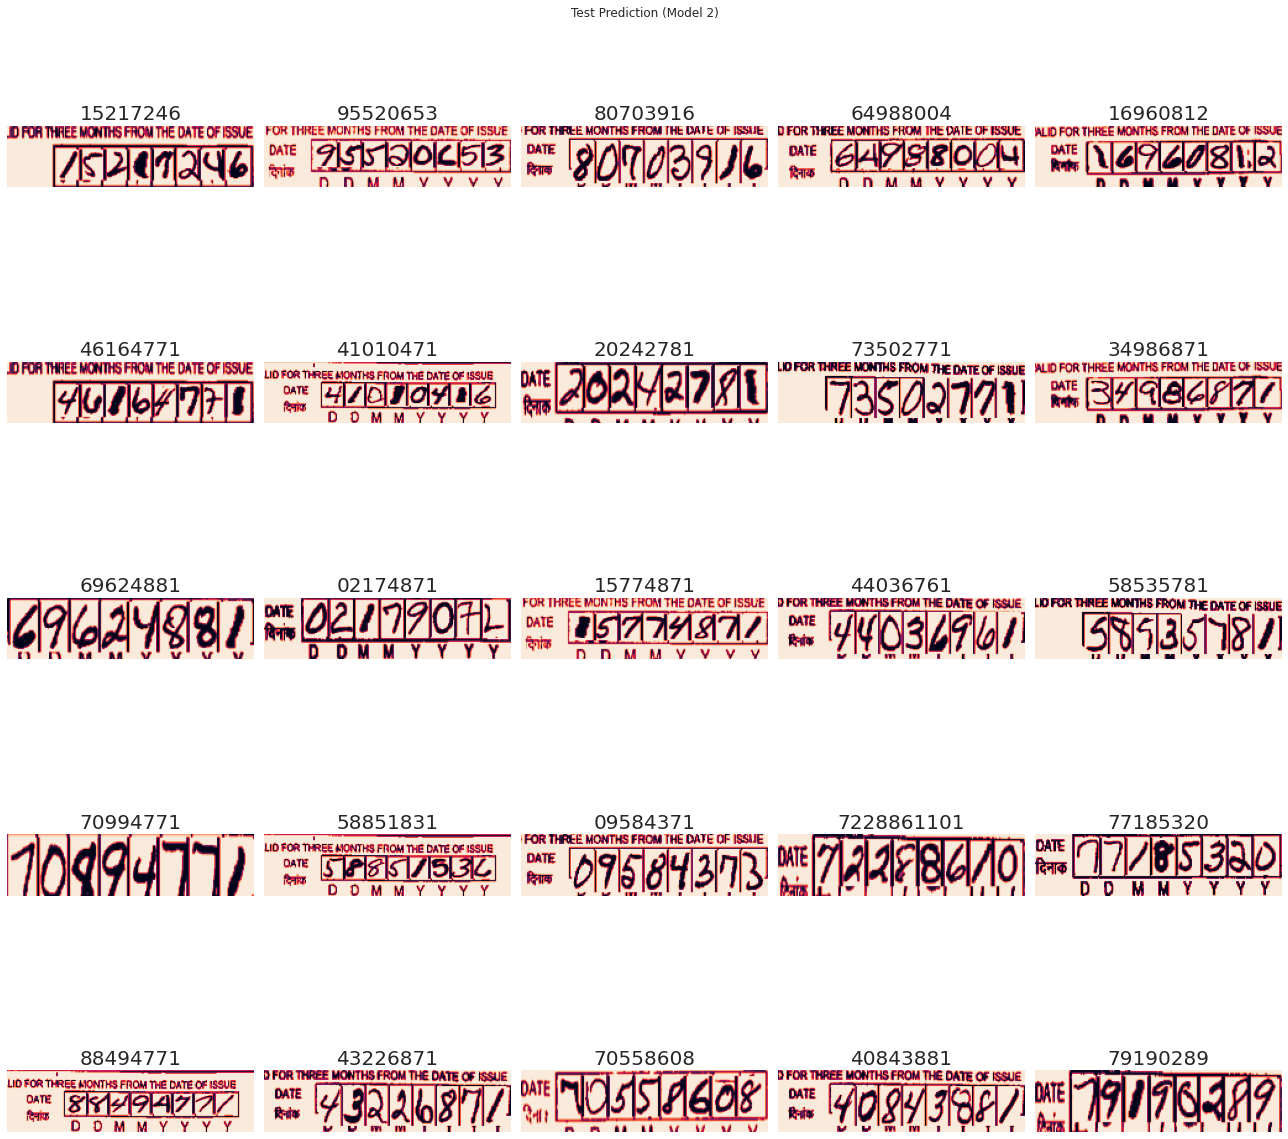

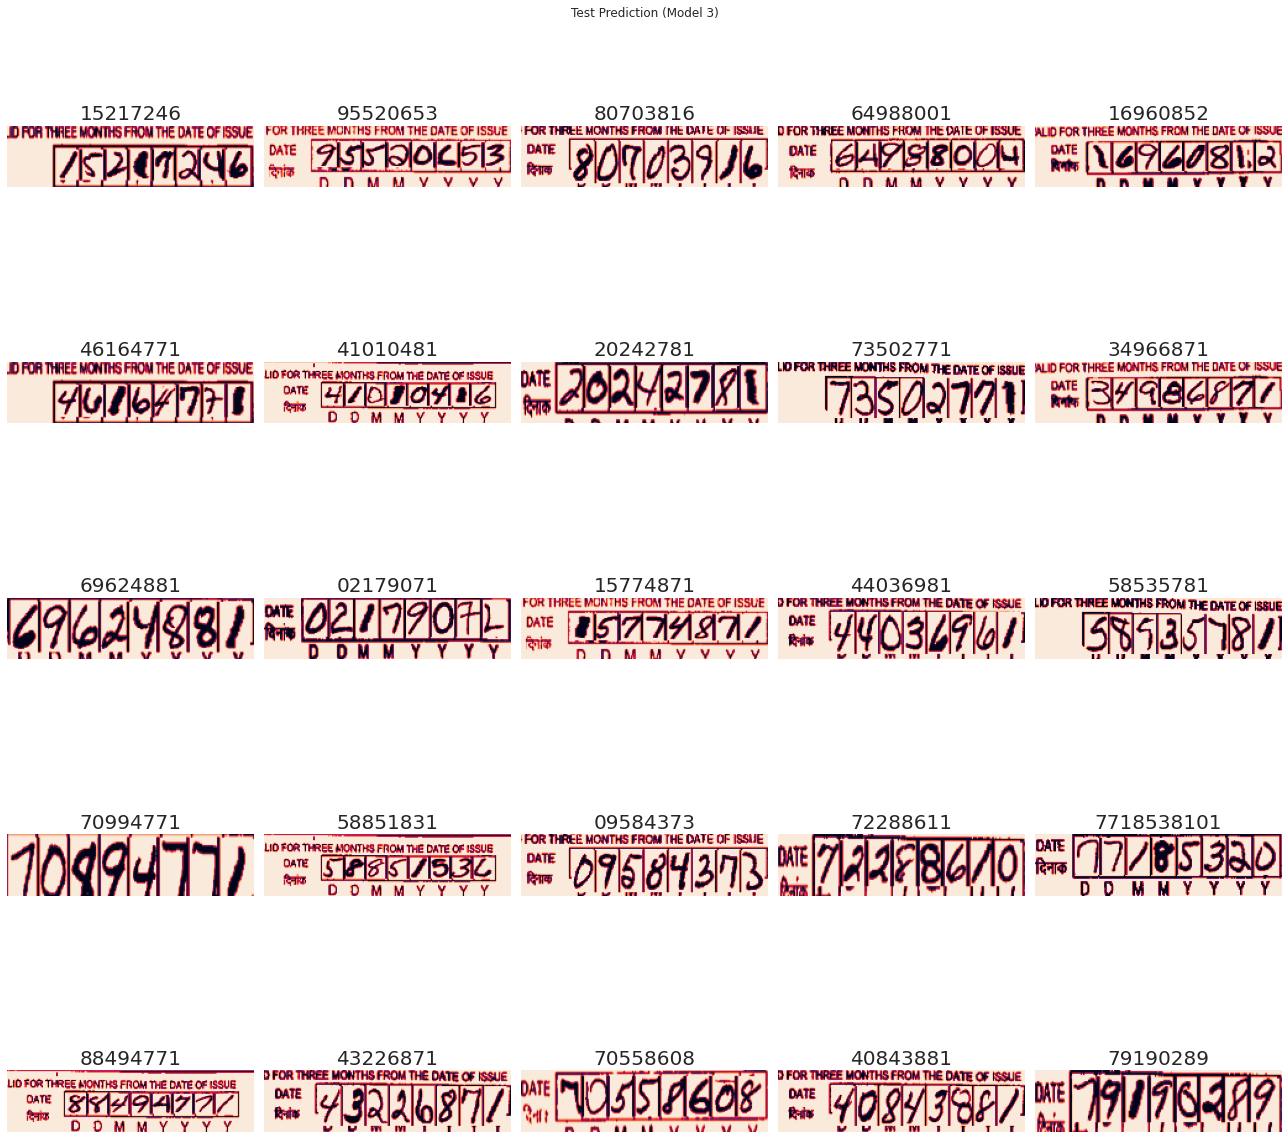

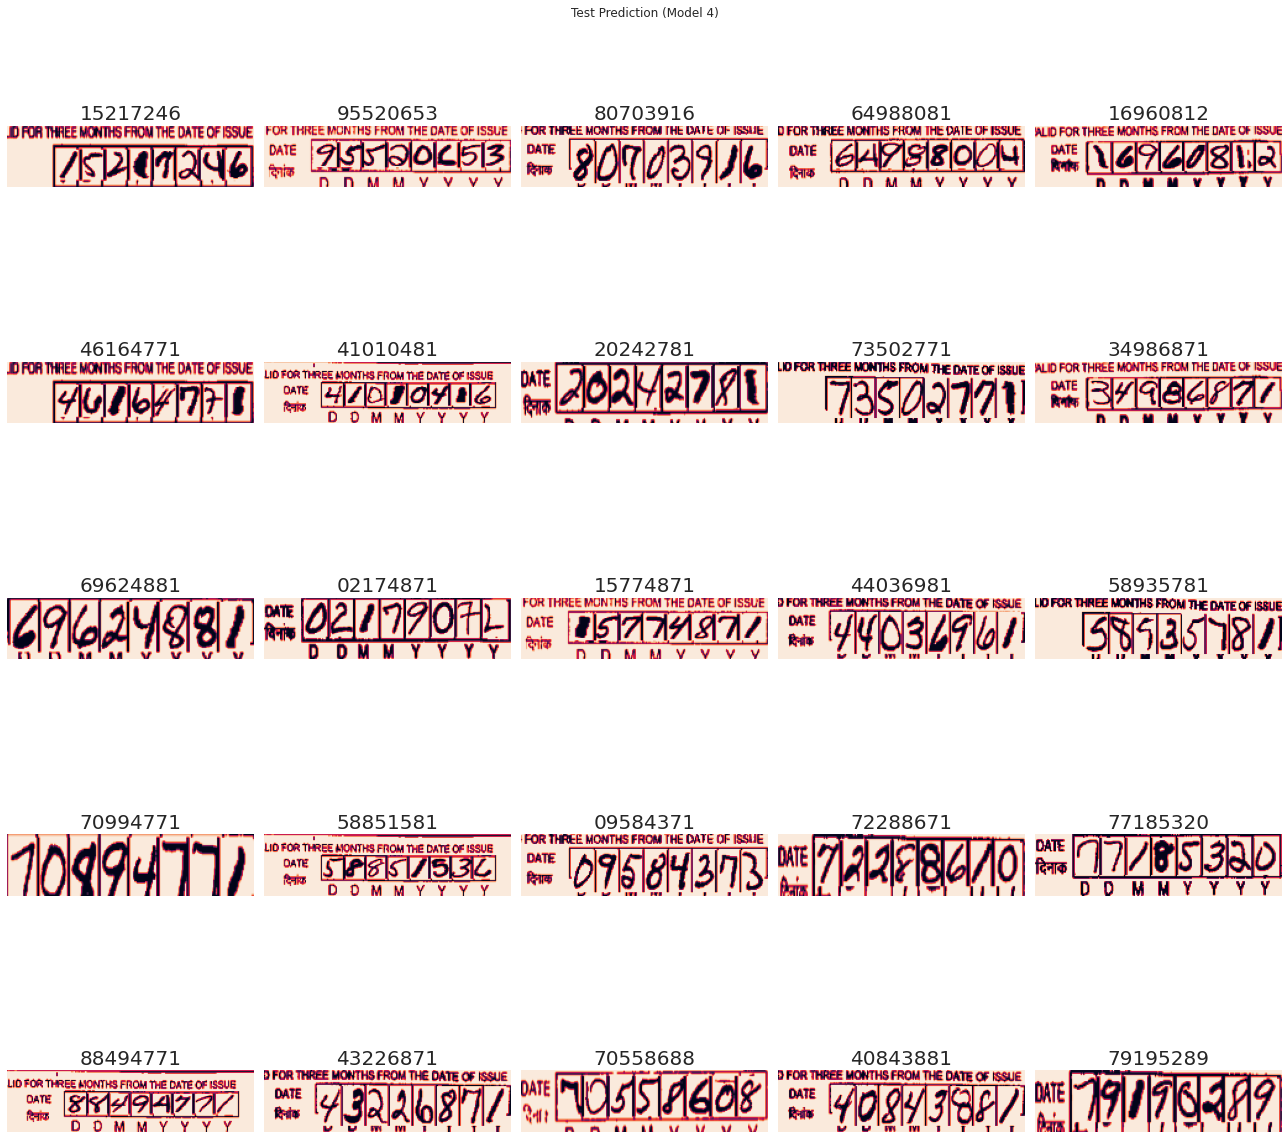

In [59]:
for fold in range(NUM_SPLITS):
    model = build_model()
    model.load_weights(f"digits_ocr_fold_{fold}.h5")
    prediction_model = keras.models.Model(
        model.get_layer(name="input_data").input, model.get_layer(name="dense2").output
    )
    
    # get test data preds
    decoded_text, _ = get_all_preds(prediction_model, test_data_generator)
    decoded_text = [remove_last_one(x) if len(x)==9 else x for x in decoded_text]
    plot_grid(testing_data, decoded_text, title=f"Test Prediction (Model {fold})")
    
    # save predictions
    submission = pd.DataFrame()
    submission["tag"] = test_df["tag"].tolist()
    submission["label"] = decoded_text
    submission.to_csv(f"submission_fold_{fold}.csv", index=False)

**Ensemble all the fold result in some manner to create a submission**

In [60]:
!rm -r raw external processed